# Perturbation modeling

Advances in single-cell experimental protocols allow for massively multiplexed experiments to measure hundreds of thousands of cells under thousands of unique conditions.
These are commonly termed "perturbations", which are temporary changes caused by an external influence {cite}`srivatsan2020`. Recently, such technologies have been adapted to profile CRISPR-Cas9 with multimodal readouts level {cite}`Papalexi2021,frangieh2021`, genome-wide perturbations {cite}`replogle2021`, and combinatorial perturbations {cite}`wessels2022`. Despite experimental advances, exploring the massive perturbation space of combinatorial gene knock-outs or drug combinations remains challenging. The vast exploration space motivated the development of computational approaches for modeling single-cell perturbation responses {cite}`ji2021`.

In the following sections we introduce three core questions of perturbation modeling:

1. Finding the cell types that were most affected the most by pertubations.
2. Predicting the transcriptional response of single-cell to perturbations.
3. Quantifying the sensitivity of genetic CRISPR perturbations.

These different questions require different approaches, and we will introduce popular ways of tackling them below.

## Identifying the cell types most affected by perturbations

### Introduction

Perturbations rarely have the same effect on all cells. Especially, different cell types or cells in different states in their cell cycle can be affected to varying degrees. Furthermore, considering that different drugs might have an easier time targeting different cell types, it is of great interest to learn which cell types were affected to which degree by the perturbations of interest. Here we will leverage [Augur](https://github.com/neurorestore/Augur) by Skinnidier et al. {cite}`Skinnider2021,Squair2021Augur` for this purpose.

Augur aims to rank or prioritize cell types according to their response to experimental perturbations given single-cell gene expression data. The basic idea is that in the space of molecular measurements cells reacting heavily to induced perturbations are more easily separated into perturbed and unperturbed groups than cell types with little or no response. This separability is quantified by measuring how well experimental labels (for example, treatment and control) can be predicted within each cell type. Augur trains a machine learning model predicting experimental labels for each cell type in multiple cross-validation runs and then prioritizes cell type response according to metric scores measuring the accuracy of the model. For categorical data the area under the curve is the default metric and for numerical data the concordance correlation coefficient is used as a proxy for model accuracy, which in turn approximates perturbation response.

Since Augur determines the degree of perturbation responses, it requires confident cell type labeling. If cell type labeling is challenging due to ongoing continuous, smooth processes or trajectories of gene expression such as cell differentiation, Augur might not allow for fine-grained enough rankings. Constructing a clustering tree describing the relationships of different clusters, which were used for cell type annotation, and applying Augur to all possible clustering resolutions, could determine the most suitable resolution and therefore annotation for the perturbation of interest {cite}`Squair2021Augur`.

Further, cell types mediating tissue- or organism-level responses to specific perturbations might themselves comprise subpopulations of responder and non-responder cells. The assignment of cells into responder and non-responder cells itself can be inaccurate because cells of a given cell type could fall along a continuous trajectory of perturbation response intensity. However, Augur does not decipher the individual cells' perturbation responses and simply aggregates them as averages for the cell types {cite}`Squair2021`.

Some perturbations might originate primarily from a change in relative abundance of a particular cell type. The subsampling procedure in Augur, however, discards any information about the relative abundances. In fact, Augur samples equal numbers of cells from each condition prior to cross-validation. Any change in the abundance of a particular cell type could be accompanied by changes in the intrinsic transcriptional profile of that cell type. Strong perturbations could even lead to scenarios where specific cell types are depleted completely or suddenly arise only when perturbed. Hence, it is advisable to perform differential abundance tests for every cell type to help contextualize the Augur analysis results {cite}`Squair2021Augur`. 

Here, we will use a fast reimplementation of the original R implementation of [Augur](https://github.com/neurorestore/Augur) using the perturbation analysis toolbox [pertpy](https://github.com/theislab/pertpy/). pertpy leverages the scverse ecosystem and is therefore fully compatible with `AnnData` in the Python ecosystem. Hence, the Python equivalent is termed Augurpy.

### Predicting cell type prioritization for IFN-β stimulation

To demonstrate Augurpy, we will use the Kang dataset, which is a 10x droplet-based scRNA-seq peripheral blood mononuclear cell (PBMC) data from 8 Lupus patients before and after 6h-treatment with INF-β (16 samples in total){cite}`kang2018`. Interferon beta is used in the form of natural fibroblast or recombinant preparations (interferon beta-1a and interferon beta-1b) and exerts antiviral and antiproliferative properties similar to those of interferon alpha. Interferon beta has been approved for the treatment of relapsing–remitting multiple sclerosis and secondary progressive multiple sclerosis.

Our goal is now to decipher which cell types were most affected by INF-β treatment. 

As a first step we import pertpy and scanpy.

In [1]:
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

# This is required to catch warnings when the multiprocessing module is used
import os

os.environ["PYTHONWARNINGS"] = "ignore"

In [2]:
import pertpy as pt
import scanpy as sc

pertpy provides a convenient data loader to access the Kang dataset.

In [3]:
adata = pt.dt.kang_2018()

Output()

We rename `label` to `condition` and the conditions themselves for improved readability.

In [4]:
adata.obs.rename({"label": "condition"}, axis=1, inplace=True)
adata.obs["condition"].replace({"ctrl": "control", "stim": "stimulated"}, inplace=True)

This dataset contains PBMCs {cite}`kang2018` across seven different cell-types.

In [5]:
adata.obs.cell_type.value_counts()

CD4 T cells          11238
CD14+ Monocytes       5697
B cells               2651
NK cells              1716
CD8 T cells           1621
FCGR3A+ Monocytes     1089
Dendritic cells        529
Megakaryocytes         132
Name: cell_type, dtype: int64

We now create an Augurpy object using pertpy based on our estimator of interest to measure how predictable the perturbation labels for each cell type in the dataset are. The options for the estimator are `random_forest_classifier` or `logistic_regression_classifier` for categorical data and `random_forest_regressor` for numerical data. All estimators make use of a `Params` class to define further parameters. Here, we will use a `random_forest_classifier` which is generally a solid and fast choice and suits our categorical data.

In [6]:
ag_rfc = pt.tl.Augurpy("random_forest_classifier")

Next, we need to load the AnnData object into a format that Augurpy is comfortable with. This can be easily done with the [load](https://pertpy.readthedocs.io/en/development/usage/tools/pertpy.tools.Augurpy.html#load) function of our Augurpy object.

In [7]:
loaded_data = ag_rfc.load(adata, label_col="condition", cell_type_col="cell_type")
loaded_data

AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'y_'
    var: 'name'
    obsm: 'X_pca', 'X_umap'

This allows us to run Augurpy with the `predict` function. Generally, Augurpy can be run in two modes: 

1. A feature selection based on `scanpy.pp.highly_variable_genes` which is also the default (`select_variance_feature=False`). This feature selection greatly reduces the number of genes that are taken into account for model training and might result in inflated Augur scores, because the highly variable genes are very useful to separate cell types. However, this mode is fast and certainly recovers the extreme effects of perturbations on cell types very well. We recommend it for very large datasets with perturbations that are expected to have a great effect on specific cell types.
2. A feature selection based on the original Augur implementation (`select_variance_feature=True`). This approach removes features with little cell-to-cell variation within that cell type. We refer to the Augur Nature Protocols paper for more details{cite}`Squair2021Augur`. When this feature selection is chosen the results are very similar to the Augur implementation in R.

Since we do not expect interferon beta to have an exceptional effect on specific cell types, we run Augurpy with the original Augur feature selection. To further increase the resolution, we set the `subsample_size` to 20 (default: 50) which corresponds to the number of cells to randomly draw per cell type.

In [8]:
v_adata, v_results = ag_rfc.predict(
    loaded_data, subsample_size=20, n_threads=4, select_variance_features=True, span=1
)

v_results["summary_metrics"]

Set smaller span value in the case of a `segmentation fault` error.

Set larger span in case of svddc or other near singularities error.

Output()

,CD14+ Monocytes,CD4 T cells,Dendritic cells,NK cells,CD8 T cells,B cells,FCGR3A+ Monocytes,Megakaryocytes
mean_augur_score,0.920476,0.669376,0.847007,0.673299,0.626247,0.783628,0.888934,0.512619
mean_auc,0.920476,0.669376,0.847007,0.673299,0.626247,0.783628,0.888934,0.512619
mean_accuracy,0.817033,0.601172,0.744249,0.610330,0.575714,0.674505,0.780330,0.510513
mean_precision,0.835072,0.630593,0.779699,0.642700,0.587059,0.742801,0.792996,0.526175
mean_f1,0.806636,0.564695,0.735157,0.591230,0.552114,0.633906,0.780933,0.406510
mean_recall,0.826349,0.575714,0.756032,0.616984,0.580000,0.622540,0.816508,0.388413


The result table contains several evaluation metrics for the fitted model. For the interpretation of the cell type prioritization of the IFN-β response, only the `mean_augur_score` is relevant, which corresponds to the `mean_auc`. The higher the value, the easier it is for the fitted model to discern between control and perturbed cell states. Hence, the perturbation effect was stronger for this cell type. Let's visualize this effect.

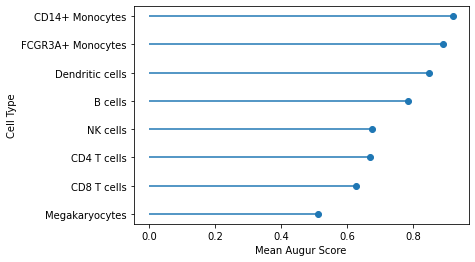

In [9]:
lollipop = pt.pl.ag.lollipop(v_results)

As observed, CD14+ Monocytes were the most affected by IFN-β whereas Megakaryocytes were the least affected. This corresponds roughly to the number of differentially expressed genes in the original publication for the respective cell types {cite}`kang2018`.

The corresponding `mean_augur_score` is also saved in `v_adata.obs` and can be plotted in a UMAP.

In [10]:
sc.pp.neighbors(v_adata)
sc.tl.umap(v_adata)

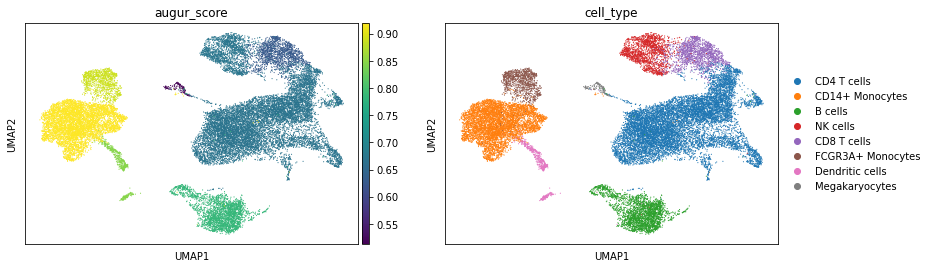

In [11]:
sc.pl.umap(adata=v_adata, color=["augur_score", "cell_type"])

### Determining the most important genes for the prioritization

The genes that contribute the most to the prioritization, as reflected by the augur score, correspond to the feature importances of our model. These feature importances are saved in the results object and can be easily plotted.

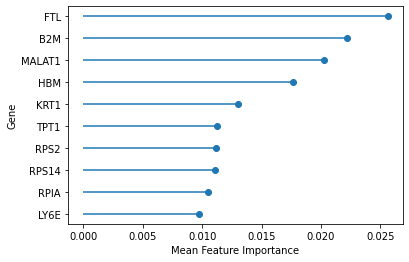

In [12]:
important_features = pt.pl.ag.important_features(v_results)

These genes could now be further explored concerning, for example, their role in pathways or other gene sets. However, since Augur performs inference on the cell type level, it does not directly determine the individual genes that are involved in the perturbation response. The authors of Augur themselves suggest using differential gene expression tests to be both conceptually and pragmatically a more appropriate approach to the inference at the level of individual genes {cite}`Squair2021Augur`.

### Differential prioritization

Augurpy is also able to perform differential prioritization which executes a permutation test to identify cell types with statistically significant differences in area under the curve (AUC) between two different rounds of cell type prioritization (for example a response to drugs A and B compared to untreated control).

In the following part, single-cell prefrontal cortex data from adult mice under cocaine self-administration from Bhattacherjee A et al. will be used {cite}`Bhattacherjee2019`. Adult mice were subject to cocaine self-administration and samples were collected at three time points: Maintance, 48h after cocaine withdrawal and 15 days after cocaine withdrawal.

We will now evaluate the effect of the `withdraw_15d_Cocaine` and `withdraw_48h_Cocaine` conditions compared to `Maintenance_Cocaine`. Basically, differential prioritization is obtained through a [permutation test](https://en.wikipedia.org/wiki/Permutation_test) of the difference in AUC between two sets of cell-type prioritizations, compared with the expected AUC difference between the same two prioritizations after random permutation of sample labels{cite}`Squair2021Augur`. In this procedure, the user first performs cell-type prioritization on drug A (`withdraw_15d_Cocaine`) and drug B (`withdraw_48h_Cocaine`) separately, then calculates the AUC difference between drug A and drug B. To compute the statistical significance of the AUC difference , an empirical null distribution of AUC differences is then calculated for each cell type by permuting the sample labels, then repeating cell-type prioritization in the permuted data. Permutation P-values are then calculated. This procedure thus enables the identification of statistically significant differences in cell-type prioritization between conditions, as well as the condition in which the cell type is more transcriptionally separable.

Each variation is run once in `default` mode and once in `permute` mode to allow us to perform the [permutation test](https://en.wikipedia.org/wiki/Permutation_test). As a first step, we fetch the `bhattacherjee` dataset using pertpy and create an Augurpy object that again uses a random forest classifier.

In [13]:
bhattacherjee_adata = pt.dt.bhattacherjee()
ag_rfc = pt.tl.Augurpy("random_forest_classifier")

Output()

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Next, we run Augurpy on `Maintenance_Cocaine` and `withdraw_15d_Cocaine` using both `augur_mode=default` and `augur_mode=permute` as previously described. Note that we log normalize the dataset for a simple normalization.

In [14]:
sc.pp.log1p(bhattacherjee_adata)

In [15]:
# Default mode
bhattacherjee_15 = ag_rfc.load(
    bhattacherjee_adata,
    condition_label="Maintenance_Cocaine",
    treatment_label="withdraw_15d_Cocaine",
)

bhattacherjee_adata_15, bhattacherjee_results_15 = ag_rfc.predict(
    bhattacherjee_15, random_state=None, n_threads=4
)
bhattacherjee_results_15["summary_metrics"].loc["mean_augur_score"].sort_values(
    ascending=False
)

Filtering samples with Maintenance_Cocaine and withdraw_15d_Cocaine labels.

Output()

Oligo         0.916088
Astro         0.912823
Microglia     0.907143
OPC           0.900397
Endo          0.780590
Excitatory    0.688617
NF Oligo      0.678730
Inhibitory    0.660023
Name: mean_augur_score, dtype: float64

In [16]:
# Permute mode
bhattacherjee_adata_15_permute, bhattacherjee_results_15_permute = ag_rfc.predict(
    bhattacherjee_15,
    augur_mode="permute",
    n_subsamples=100,
    random_state=None,
    n_threads=4,
)

Output()

Now let's do the same for `Maintenance_Cocaine` and `withdraw_48h_Cocaine`.

In [17]:
# Default mode
bhattacherjee_48 = ag_rfc.load(
    bhattacherjee_adata,
    condition_label="Maintenance_Cocaine",
    treatment_label="withdraw_48h_Cocaine",
)

bhattacherjee_adata_48, bhattacherjee_results_48 = ag_rfc.predict(
    bhattacherjee_48, random_state=None, n_threads=4
)

bhattacherjee_results_48["summary_metrics"].loc["mean_augur_score"].sort_values(
    ascending=False
)

Filtering samples with Maintenance_Cocaine and withdraw_48h_Cocaine labels.

Output()

Inhibitory    0.675272
Astro         0.664728
OPC           0.628141
Microglia     0.614116
Endo          0.603107
Oligo         0.589728
NF Oligo      0.587596
Excitatory    0.559229
Name: mean_augur_score, dtype: float64

In [18]:
# Permute mode
bhattacherjee_adata_48_permute, bhattacherjee_results_48_permute = ag_rfc.predict(
    bhattacherjee_48,
    augur_mode="permute",
    n_subsamples=100,
    random_state=None,
    n_threads=4,
)

Output()

Skipping NF Oligo cell type - 79 samples is less than min_cells 100.

This allows us to take a look at the augur scores of the two runs in a scatterplot. The diagonal line is the identity function. If the values were the same they would be on the line.

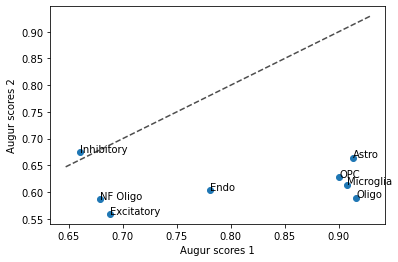

In [19]:
scatter = pt.pl.ag.scatterplot(bhattacherjee_results_15, bhattacherjee_results_48)

To figure out which cell type was most affected when comparing `withdraw_48h_Cocaine` and `withdraw_15d_Cocaine` we can run differential prioritization.

In [20]:
pvals = ag_rfc.predict_differential_prioritization(
    augur_results1=bhattacherjee_results_15,
    augur_results2=bhattacherjee_results_48,
    permuted_results1=bhattacherjee_results_15_permute,
    permuted_results2=bhattacherjee_results_48_permute,
)
pvals

,cell_type,mean_augur_score1,mean_augur_score2,delta_augur,b,m,z,pval,padj
0,Endo,0.780590,0.603107,-0.177483,1000,1000,-12.768461,0.001998,0.002331
1,OPC,0.900397,0.628141,-0.272256,1000,1000,-14.543180,0.001998,0.002331
2,Excitatory,0.688617,0.559229,-0.129388,1000,1000,-8.456439,0.001998,0.002331
3,Microglia,0.907143,0.614116,-0.293027,788,1000,-19.857981,0.425574,0.425574
4,Inhibitory,0.660023,0.675272,0.015249,1000,1000,3.218067,0.001998,0.002331
5,Astro,0.912823,0.664728,-0.248095,1000,1000,-17.167407,0.001998,0.002331
6,Oligo,0.916088,0.589728,-0.326361,1000,1000,-19.445162,0.001998,0.002331


The p-value, following the R Augur implementation is calculated using `b`, the number of times permuted values are larger than original values and `m`, the number of permutations run. Since `b` is the same for all cells but OPC, the p-value is the same for these as well.

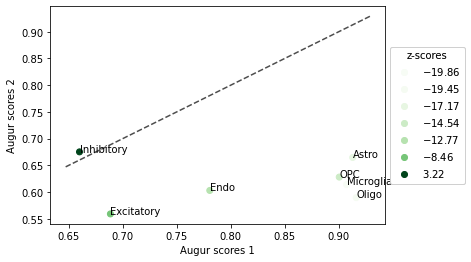

In [21]:
diff = pt.pl.ag.dp_scatter(pvals)

In this case the cell type Microglia has the lowest p-value, meaning that in comparing the impact of `withdraw_48h_Cocaine` and `withdraw_15d_Cocaine`, this cell type was most perturbed.

## Predicting IFN-β response for CD4-T cells


Perturbation response modeling methods aim to forecast transcriptomic responses to stimuli, be it drugs, genetic knock-outs, or disease, for unseen populations where the perturbation response has not been measured. The main application of perturbation response modeling is to help facilitate experimental design and hypothesis generation. The failure to capture cells treated with a perturbation could happen when a specific population could not be measured due to experimental or sample failure (e.g., failed cell sorting), high experimental costs prohibiting exploring all possibilities, and rare frequency of discovery for some cell types. In all scenarios above, an in-silico prediction of the missing population can lead to an informed decision about conducting new experiments or not.

Multiple methods for perturbation response modeling have been developed based on autoencoders (AE){cite}`lotfollahi2019,lotfollahi2020,lotfollahi2021,russkikh2020,yuan2021,amodio2018,wei2022`, a deep learning architecture to learn a low-dimensional representation of the data. The fundamental principle of autoencoders is that they are composed of two parts, an encoder and a decoder. The encoder tries to learn a latent space of the input data (usually gene expression) which can be decoded with minimal reconstruction error by the decoder. The latent space is usually of a lower dimension than the input space.
An extension of AEs are variational autoencoders (VAE) that address the issue of non-regularized latent spaces of AEs by providing generative capability to the entire space. A non-regularized latent space only really provides strong sampling capability for the distinct classes that formed clusters. The famous MNIST dataset of handwritten digits would only allow the sampling of the digits 0-9 in any of the determined 10 clusters. However, it would result in garbage input if sampling were attempted outside the clusters. Whereas, the encoder in AEs outputs latent vectors, the encoder in VAEs outputs parameters of a pre-defined distribution in the latent space for every input. The latent space gets regularized by the VAE enforcing a normally distributed latent distribution.


Here, we demonstrate the application of scGen {cite}`lotfollahi2019`, a variational autoencoder combined with vector arithmetics. The model learns a latent representation of the data in which it estimates a difference vector between control (untreated) and perturbed (treated) cells. The estimated difference vector is then added to control cells for the cell type or population of interest to predict the gene expression response for each single cell. Here, we demonstrate the application scGen to predict the response to IFN-β for a population of CD4-T cells that are artificially held out (unseen) during training to simulate a real-world scenario mentioned before. To this end, we leverage a dataset that contains peripher blood mononuclear cells (PBMCs) from eight patients with Lupus treated with IFN-β or left untreated from {cite}`kang2018` across seven different cell-types.

As a first step, we import `scanpy` and `scgen` to allow us to work with AnnData objects and employ scGen.

In [15]:
import scanpy as sc
import pertpy as pt
import scgen

Global seed set to 0


### Setting up the Kang dataset for scGen

We will again use [pertpy](https://github.com/theislab/pertpy/) to get the Kang dataset.

In [16]:
adata = pt.dt.kang_2018()

scGen works best with log transformed data. Highly variable gene selection can ensure that scGen only focuses on the most varying and therefore potentially biologically relevant genes. It can also speed up the computation.

In [17]:
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)

We rename `label` to `condition` and the conditions themselves for improved readability.

In [18]:
adata.obs.rename({"label": "condition"}, axis=1, inplace=True)
adata.obs["condition"].replace({"ctrl": "control", "stim": "stimulated"}, inplace=True)

This dataset contains PBMCs {cite}`kang2018` across seven different cell-types.

In [19]:
adata.obs.cell_type.value_counts()

CD4 T cells          11238
CD14+ Monocytes       5697
B cells               2651
NK cells              1716
CD8 T cells           1621
FCGR3A+ Monocytes     1089
Dendritic cells        529
Megakaryocytes         132
Name: cell_type, dtype: int64

We remove all CD4T cells from the training data (`adata_t`) to simulate a real-world scenario of not capturing a specific population during an experiment.

In [20]:
adata_t = adata[
    ~(
        (adata.obs["cell_type"] == "CD4 T cells")
        & (adata.obs["condition"] == "stimulated")
    )
].copy()

cd4t_stim = adata[
    (
        (adata.obs["cell_type"] == "CD4 T cells")
        & (adata.obs["condition"] == "stimulated")
    )
].copy()

scGen requires the data to be in a particular format which is facilitated through `AnnData` and the `setup_anndata` function. It requires the key of the sample, the `batch_key` (in our case, `"condition"`) and the cell type label key, the `labels_key` (`"cell_type"`), which are later used for the model's internal computations.

In [21]:
scgen.SCGEN.setup_anndata(adata_t, batch_key="condition", labels_key="cell_type")

### Model construction and training

scGen requires the modified `AnnData` object (`adata_t`) to construct the model object, which can be used to train the model. This function receives multiple user inputs, including the number of nodes in each hidden layer (`n_hidden`) of the model before the bottleneck layer (the middle layer of the network) and also the number of such layers (`n_layers`). Additionally, the user can adapt the dimension of the bottleneck layer, which is used to calculate the difference vector between perturbed cells and control cells. The parameters used here are taken from the original publication as default. In practice, wider hidden layers lead to better reconstruction accuracy, which is essential for our aim to predict the perturbation response across many genes.

In [22]:
model = scgen.SCGEN(adata_t, n_hidden=800, n_latent=100, n_layers=2)

scGen is a neural network with thousands of parameters to learn a low-dimensional data representation. Here, we use `train` method to estimate these parameters using the training data. There are multiple parameters here, `max_epochs` is the maximum number of iterations the model is allowed to update its parameters which are set to 100 here. The higher values training epochs will take more computation time but might help better results. The `batch_size` is the number of samples (individual cells) the model sees to update its parameters. Lower numbers usually lead to better results in the case of scGen. Finally, there is `early_stopping`, which enables the model to stop the training if its results are not improved after `early_stopping_patience` training epochs. The early stopping mechanism prevents potential overfitting of the training data, which can lead to poor generalization to unseen populations.  

In [23]:
model.train(
    max_epochs=100, batch_size=32, early_stopping=True, early_stopping_patience=25
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Epoch 27/100:  27%|██▋       | 27/100 [1:01:41<2:46:48, 137.11s/it, loss=140, v_num=1]
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 665.237. Signaling Trainer to stop.


To visualize the learned representation of data by the model, we plot the latent representation of the model using the UMAP algorithm. The `get_latent_representation()`  returns a 100-dimensional vector for each cell. We store the latent representations in the `.obsm` slot of the AnnData object.

In [24]:
adata_t.obsm["scgen"] = model.get_latent_representation()

Next, we recalculate the neighbors graph and the UMAP embedding using the calculated latent representation to finally visualize the new embedding in a UMAP plot.

In [25]:
sc.pp.neighbors(adata_t, use_rep="scgen")
sc.tl.umap(adata_t)

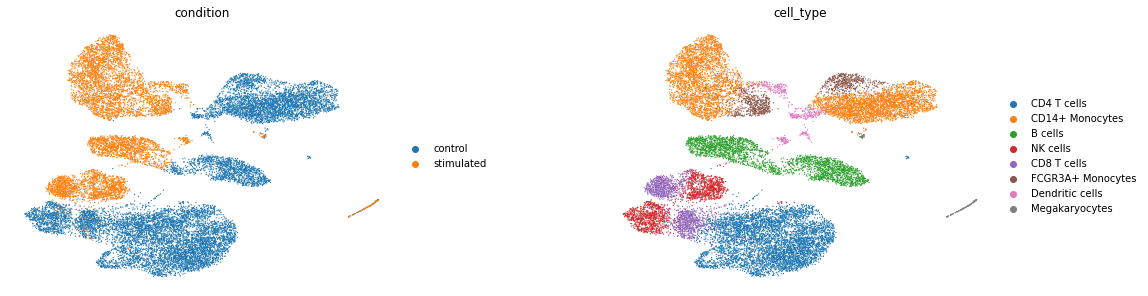

In [26]:
sc.pl.umap(adata_t, color=["condition", "cell_type"], wspace=0.4, frameon=False)

As observed above, the IFN-β stimulation indcuced strong transcriptional changes across all cell-types 

### Predicting CD4T responses to IFN-β stimulation

After the model is trained, we can ask the model to simulate the effect of IFN-β response for each control CD4T cell present in the training data. The prediction is made possible via the `predict` method, which receives the corresponding labels (`ctrl_key` and `stim_key` below) in the `condition` (as provided earlier by the user) column of the `AnnData` object to estimate a global the difference vector in the latent space between 'control' and 'stimulated' cells. This vector is then added to each single-cell present specified in `celltype_to_predict` (here CD4T). 



In [27]:
pred, delta = model.predict(
    ctrl_key="control", stim_key="stimulated", celltype_to_predict="CD4 T cells"
)

# we annotate the predicted cells to distinguish them later from ground truth cells.
pred.obs["condition"] = "predicted stimulated"

INFO     Received view of anndata, making copy.                                              
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Received view of anndata, making copy.                                              
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Received view of anndata, making copy.                                              
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       


### Evaluating the predicted IFN-β response

In previous sections, we predicted the response to IFN-β for each CD4T cell present among the control population. Since single-cell sequencing is destructive, meaning that cells can not be measured before and after a particular perturbation, it is impossible to directly evaluate the prediction for the same cell after IFN-β stimulation. However, we have a group of cells in the data treated with IFN-β, which we can use to measure how well the predicted cell population aligns with ground truth cells. To pursue this, we evaluate predictions qualitatively by looking at the embedding of control, predicted, and actual CD4t IFN-β cells in principal component analysis (PCA) space. Additionally, we also quantitatively measure the correlation between mean gene expression of predicted cells and IFN-β across all genes and differentially expressed genes after IFN-β stimulaton.

First, we construct an `AnnData` object containing control, predicted stimulated, and actual stimulated cells.

In [28]:
ctrl_adata = adata[
    ((adata.obs["cell_type"] == "CD4 T cells") & (adata.obs["condition"] == "control"))
]
# concatenate pred, control and real CD4 T cells in to one object
eval_adata = ctrl_adata.concatenate(cd4t_stim, pred)

In [29]:
eval_adata.obs.condition.value_counts()

stimulated              5678
control                 5560
predicted stimulated    5560
Name: condition, dtype: int64

We first look at the PCA co-embedding of control, IFN-β stimulated and predicted CD4T cells.

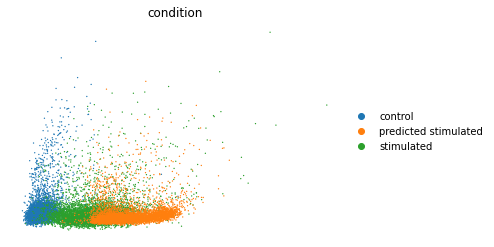

In [30]:
sc.tl.pca(eval_adata)
sc.pl.pca(eval_adata, color="condition", frameon=False)

As observed above, the predicted stimulated cells were moved towards the CD4T stimulated cells with IFN-β. Yet we should also look at differentially expressed genes (DEGs) to verify whether the most striking DE genes are also present in the predicted stimulated cells. Below, we look at the overall mean correlation between predicted and real cells. Before that, we extract DEGs between control and stimulated cells:

In [31]:
cd4t_adata = adata[adata.obs["cell_type"] == "CD4 T cells"]

We estimate DEGs using scanpy's implementation of the Wilcoxon test.

In [32]:
sc.tl.rank_genes_groups(cd4t_adata, groupby="condition", method="wilcoxon")
diff_genes = cd4t_adata.uns["rank_genes_groups"]["names"]["stimulated"]
diff_genes

array(['ISG15', 'IFI6', 'ISG20', ..., 'EEF1A1', 'FTH1', 'RGCC'],
      dtype=object)

scGen features a `reg_mean_plot` that calculates the R² correlation between mean gene expression of predicted and existing IFN-β cells. The higher the R² (max is 1), the more faithful is the prediction compared to the ground truths. The highlighted genes in red are the top 10 upregulated DEGs after IFN-β stimulation, which are essential for a successful prediction. As observed, the model did a good job for genes with higher mean values, while it failed for some genes with a mean expression between 0-1. The reason we measure the accuracy across non-DEGs is that the model should not chance the genes not affected by the perturbation while changing the expression of DEGs.   

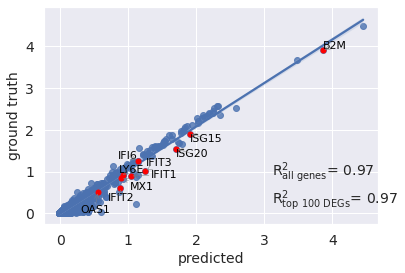

In [33]:
r2_value = model.reg_mean_plot(
    eval_adata,
    axis_keys={"x": "predicted stimulated", "y": "stimulated"},
    gene_list=diff_genes[:10],
    top_100_genes=diff_genes,
    labels={"x": "predicted", "y": "ground truth"},
    show=True,
    legend=False,
)

We can additionally look at the distribution of the top upregulated genes by IFN-β. For example, we plotted the distribution of expression in `ISG15`, a well-known gene induced after IFN stimulation. As observed, the model identified that this gene should be upregulated after stimulation with IFN-β, and it indeed shifted values to a similar range in ground-truth (stimulated) cells.

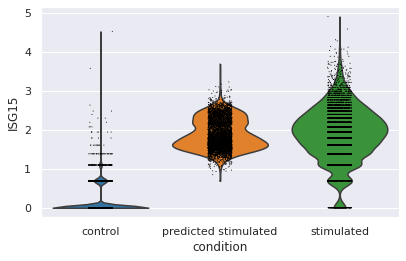

In [34]:
sc.pl.violin(eval_adata, keys="ISG15", groupby="condition")

Overall, we demonstrated the application of scGen as an example of perturbation response models in predicting gene expression of the unseen population under desired perturbations. While perturbation response models provide in silico predictions, they cannot replace performing actual experiments. However, as observed in the case of scGen, it can predict the overall response for highly expressed genes yet provide poorer predictions for lowly expressed genes, which requires further optimization and motivation for developing more sophisticated and robust approaches.  

## Analysing single-pooled CRISPR screens

Expanded CRISPR-compatible CITE-seq (ECCITE-seq) enables the capture of single guide RNA (sgRNA) sequences together with transcriptome and surface protein measurements in the form of antibody-derived tags (ADTs). This allows for the application of many genetic perturbations together with transcriptomics readouts for effect exploration and validation of the perturbations through protein expression, making this assay very powerful. However, this power comes not only with great responsibility, but also with complexity.

:::{figure-md} eccite-seq

<img src="../_static/images/eccite.png" alt="ECCITE-seq Overview" class="bg-primary mb-1" width="800px">

ECCITE-seq overview. mRNA is measured together with surface protein expression using antibody derived tags. Biological replicates are resolved through hashtag-derived oligonucleotides. The assignment of the guide RNAs is done using guide-derived oligonucleotides. Image obtained from (https://cite-seq.com/eccite-seq).

:::

For the purpose of this analysis we will be using the Papalexi 2021 dataset {cite}`Papalexi2021`. This dataset contains about 20000 measured stimulated THP-1 cells that used 111 gRNAs. THP-1 cells stimulated with a combination of IFN-y, decitabine (DAC) and transforming growth factor (TGF)-β1 results in an induction of three immune checkpoints: programmed death-ligand 1 (PD-L1), PD-L2 and CD86. The goal of the ECCITE-seq experiment was to investigate molecular networks that regulate PD-L1 expression, because it is frequently observed in human cancers and can suppress T-cell-mediated immune responses {cite}`Papalexi2021`.

For this specific analysis, we want to:

1. Remove confounding sources of variation such as cell cycle effects or batch effects.
2. Determine which cells were affected by the desired perturbations and which cells escaped.
3. Visualize perturbation responses.

To conduct this analysis we will again use pertpy which implements the Mixscape pipeline for the scverse ecosystem about 5-10x faster. This pipeline was originally developed for the Seurat ecosystem, and we largely follow the accompanying Seurat Vignette (https://satijalab.org/seurat/articles/mixscape_vignette.html).

We start by importing pertpy, scanpy and muon, which we will require for the preprocessing of the protein data.

In [13]:
import pertpy as pt
import muon as mu
import scanpy as sc

As a first step we fetch the dataset using pertpy. The return type of the dataloader is a MuData object containing the transcriptomics measurements, the ADT measurements and guide RNA counts.

In [14]:
mdata = pt.dt.papalexi_2021()
mdata

Output()

MuData object with n_obs × n_vars = 20729 × 18778
  4 modalities
    rna:	20729 x 18649
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase'
      var:	'name'
    adt:	20729 x 4
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase'
      var:	'name'
    hto:	20729 x 12
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase'
      var:	'name'
    gdo:	20729 x 111
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase'
      var:	'name'

The original Seurat object contained four assays which were transformed into individual AnnData objects to then create the here downloaded MuData object. The individual modalities are:

1. `adt`: A count matrix of the four captured antibody-derived tags (CD86, PDL1, PDL2, CD366) which are also commonly simply referred to as "proteins" in this setting.
2. `gdo`: The 111 used guide RNAs (gRNA). To assign a gRNA identity to each cell, guide-derived oligonucleotide (GDO) counts were examined. If a cell had less than five counts for all gRNA sequences, it was classified as negative. For all other cells, the gRNA with the highest number of counts was assigned to that cell. Cells that had high counts for more than one gRNA were classified as doublets.
3. `hto`: To keep track of the identity of each biological replicate, the samples were hashed using hashtag-derived oligonucleotides (HTO) following the cell hashing protocol {cite}`Stoeckius2018`.
4. `rna`: This corresponds to the transcriptome measurements for all cells and is the usual cells by genes count matrix.

### Preprocessing

We keep the preprocessing of the RNA and ADTs simple. First, we normalize the RNA using scanpy's `normalize_total` followed by log transformation and highly variable gene selection. To normalize the ADTs we apply centered log ration transformation {cite}`Stoeckius2017`.

In [15]:
sc.pp.normalize_total(mdata["rna"])
sc.pp.log1p(mdata["rna"])
sc.pp.highly_variable_genes(mdata["rna"], subset=True)

In [16]:
mu.prot.pp.clr(mdata["adt"])

### Data exploration

To get a feeling for our dataset we visualize the replicates, cell-cycle phases and perturbations in a UMAP embedding.

In [17]:
sc.pp.pca(mdata["rna"])

In [18]:
# We calculate neighbors with the cosine distance similarly to the original Seurat implementation
sc.pp.neighbors(mdata["rna"], metric="cosine")

In [19]:
sc.tl.umap(mdata["rna"])

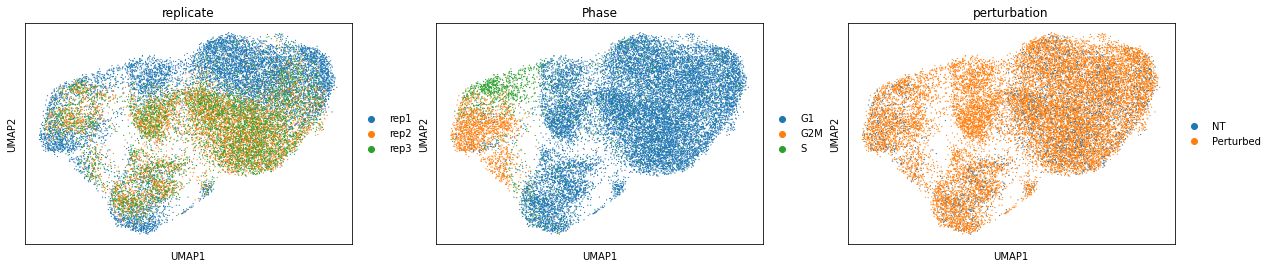

In [20]:
sc.pl.umap(mdata["rna"], color=["replicate", "Phase", "perturbation"])

When glancing at the UMAPs we identify two clearly visible issues:

1. Many cells are separated by replicate ID. This is a common sign of a batch effect.
2. The cell cycle phase is a confounder in the embedding.

Hence, we now try to project our cells into a perturbation space by calculating local perturbation signatures to mitigate these identified issues.

### Calculating local perturbation signatures

To alleviate the aforementioned issues, we will calculate local perturbation signatures. The core idea is that by subtracting the averaged expression of the `k` nearest cells from the control pool (=NT) from every cell, we retrieve the component of every cell that solely reflects the genetic perturbation. The `k` nearest neighbors must be in a biological state matching the target cell, but are not allowed to have been targeted by any gRNA. The obtained component is denoted as the local perturbation signature. By default, the number of neighbors `k` is set to 20. Following the recommendations of Papalexi et al., we recommend setting from the range of 20 < `k` 30. A `k` that is too small or too large is unlikely to remove any technical variation from the dataset {cite}`Papalexi2021`.

We now create a Mixscape object of pertpy and calculate the perturbation signature.

In [21]:
ms = pt.tl.Mixscape()

ms.pert_sign(
    mdata["rna"],
    pert_key="perturbation",
    control="NT",
    split_by="replicate",
    n_neighbors=20,
)

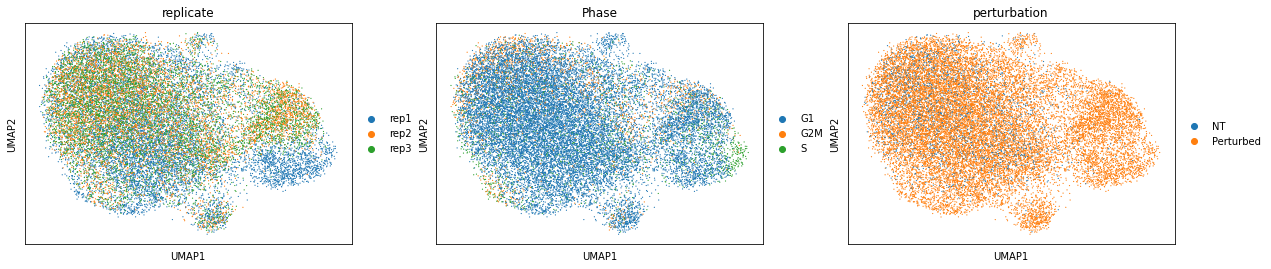

In [22]:
# We create a copy of the object to recalculate the PCA.
# Alternatively we could replace the X of the RNA part of our MuData object with the `X_pert` layer.
adata_pert = mdata["rna"].copy()
adata_pert.X = adata_pert.layers["X_pert"]
sc.pp.pca(adata_pert)
sc.pp.neighbors(adata_pert, metric="cosine")
sc.tl.umap(adata_pert)
sc.pl.umap(adata_pert, color=["replicate", "Phase", "perturbation"])

Using the perturbation signature to cluster the cells removes technical variation and reveals one additional perturbation-specific cluster. Now that our data is mostly free of confounding effects, we need to determine for which targeted cells (=perturbed) the perturbation was successful (=KO) or not (=NP).

### Identifying cells with no detectable perturbation

The primary assumption that we make is that every target gene class is a mixture of two Gaussian distributions. One of these represents the successful knockouts (KO) and the other the non-perturbed (NP) cells. The distribution of the NP cells should then be identical to the cells expressing non-targeting gRNAs (NT). After having estimated the distribution of the KO cells, Mixscape calculates the posterior probability that a cell belongs to the KO distribution and classifies cells with a probability of more than 0.5 as KOs. Applying this to all 11 target gene classes allows us to identify all KO cells while evaluating the targeting efficacy of the different gRNAs.

In [23]:
ms.mixscape(adata=mdata["rna"], control="NT", labels="gene_target", layer="X_pert")

We can now plot the class distributions for all 111 gRNAs.

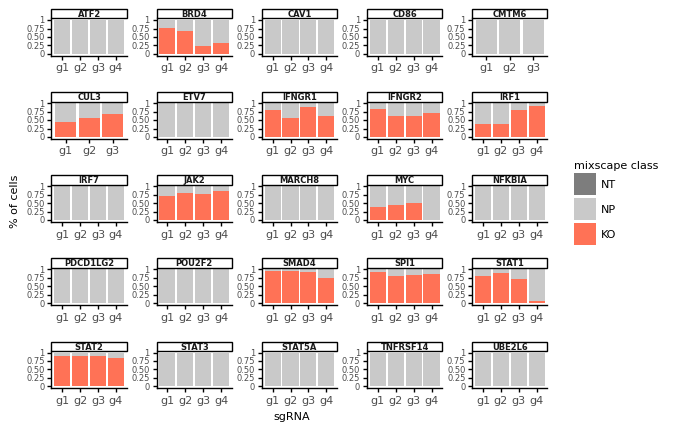

<ggplot: (8793801394204)>

In [24]:
pt.pl.ms.barplot(mdata["rna"])

We detect variation in gRNA targeting efficiency within each class. For example gRNA 4 for STAT1 did not seem to be very effective, but gRNA 1-3 were.

Let's inspect the perturbation scores of an example target gene (IFNGR2). 

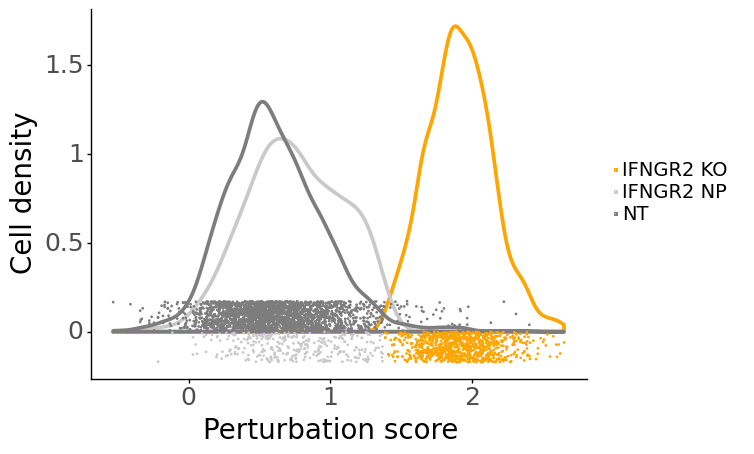

<ggplot: (8793804547229)>

In [25]:
pt.pl.ms.perturbscore(
    adata=mdata["rna"], labels="gene_target", target_gene="IFNGR2", color="orange"
)

As expected, the distributions of the NT and IFNGR2 NP classes match rather well, whereas the IFGNR2 KO distribution is clearly shifted. This should also be reflected in the posterior probabilities.

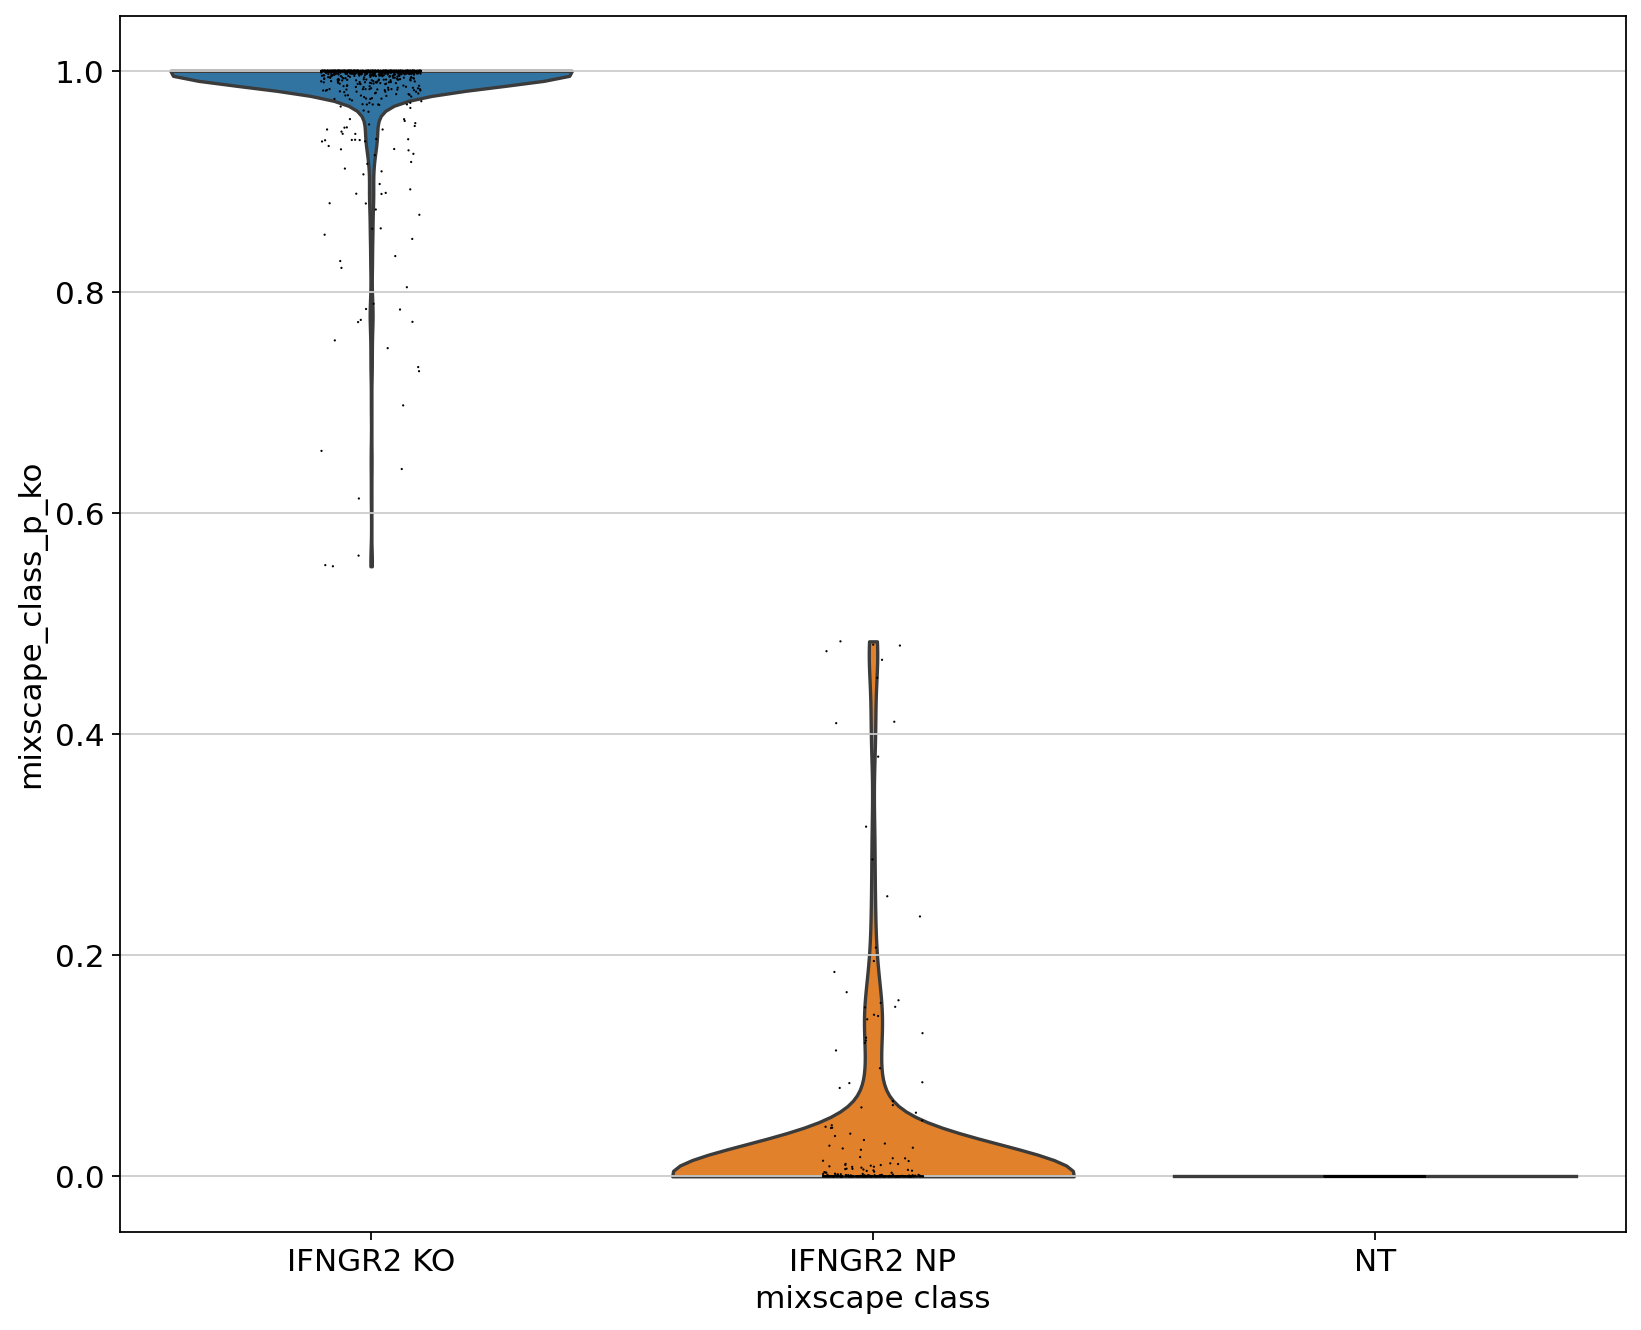

In [26]:
sc.settings.set_figure_params(figsize=(10, 10))
pt.pl.ms.violin(
    adata=mdata["rna"],
    target_gene_idents=["NT", "IFNGR2 NP", "IFNGR2 KO"],
    groupby="mixscape_class",
)

The posterior probabilities clearly separate the two classes highlighting very few unclear cases. This can be further highlighted by running a simple DE test and visualizing the results on a heatmap by ordering the posterior probabilities.

categories: IFNGR2 KO, IFNGR2 NP, NT
var_group_labels: NT


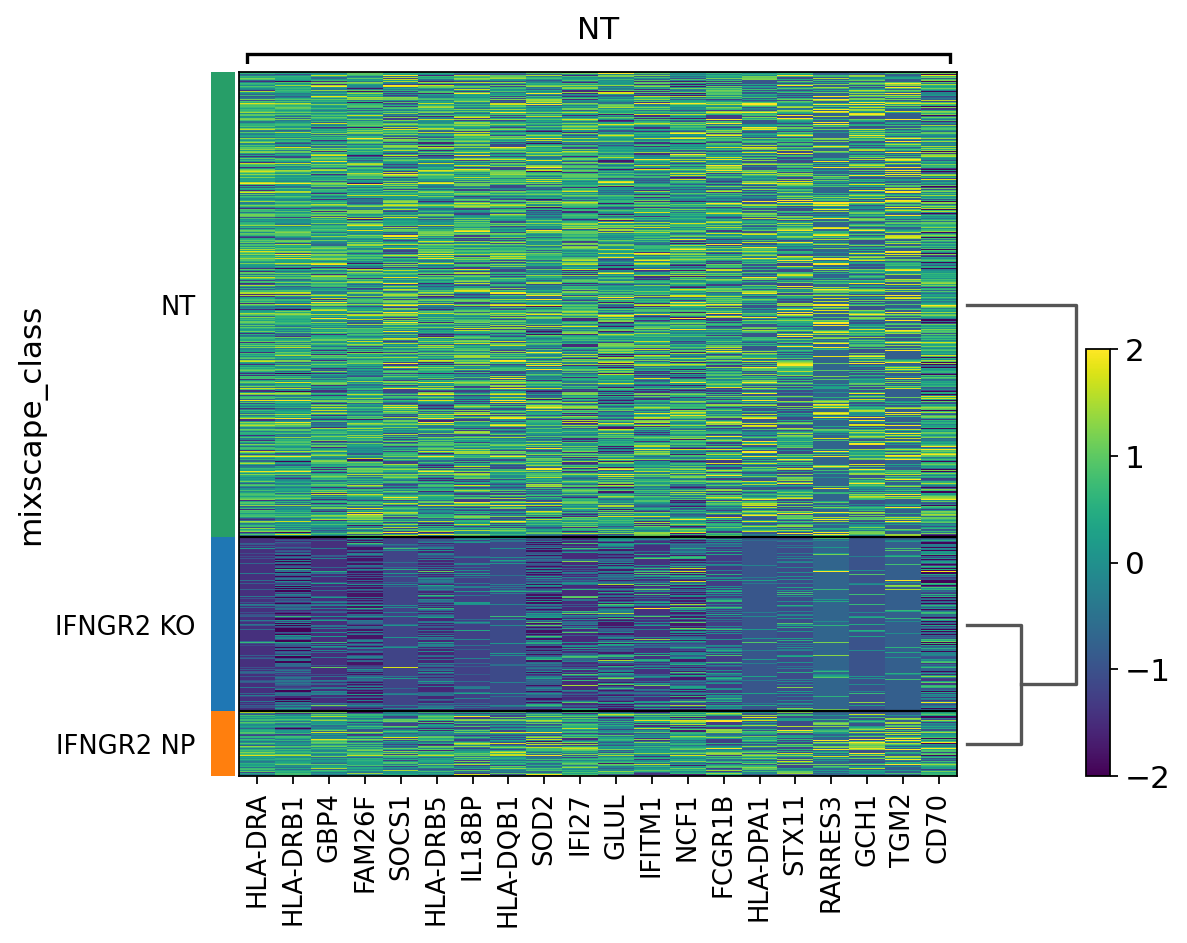

In [27]:
pt.pl.ms.heatmap(
    adata=mdata["rna"],
    labels="gene_target",
    target_gene="IFNGR2",
    layer="X_pert",
    control="NT",
)

Up to this point we have only been working with the transcriptomics data, but we can now leverage the measured proteins to demonstrate that only IFGN pathway KO cells have a reduction in PDL1 expression.

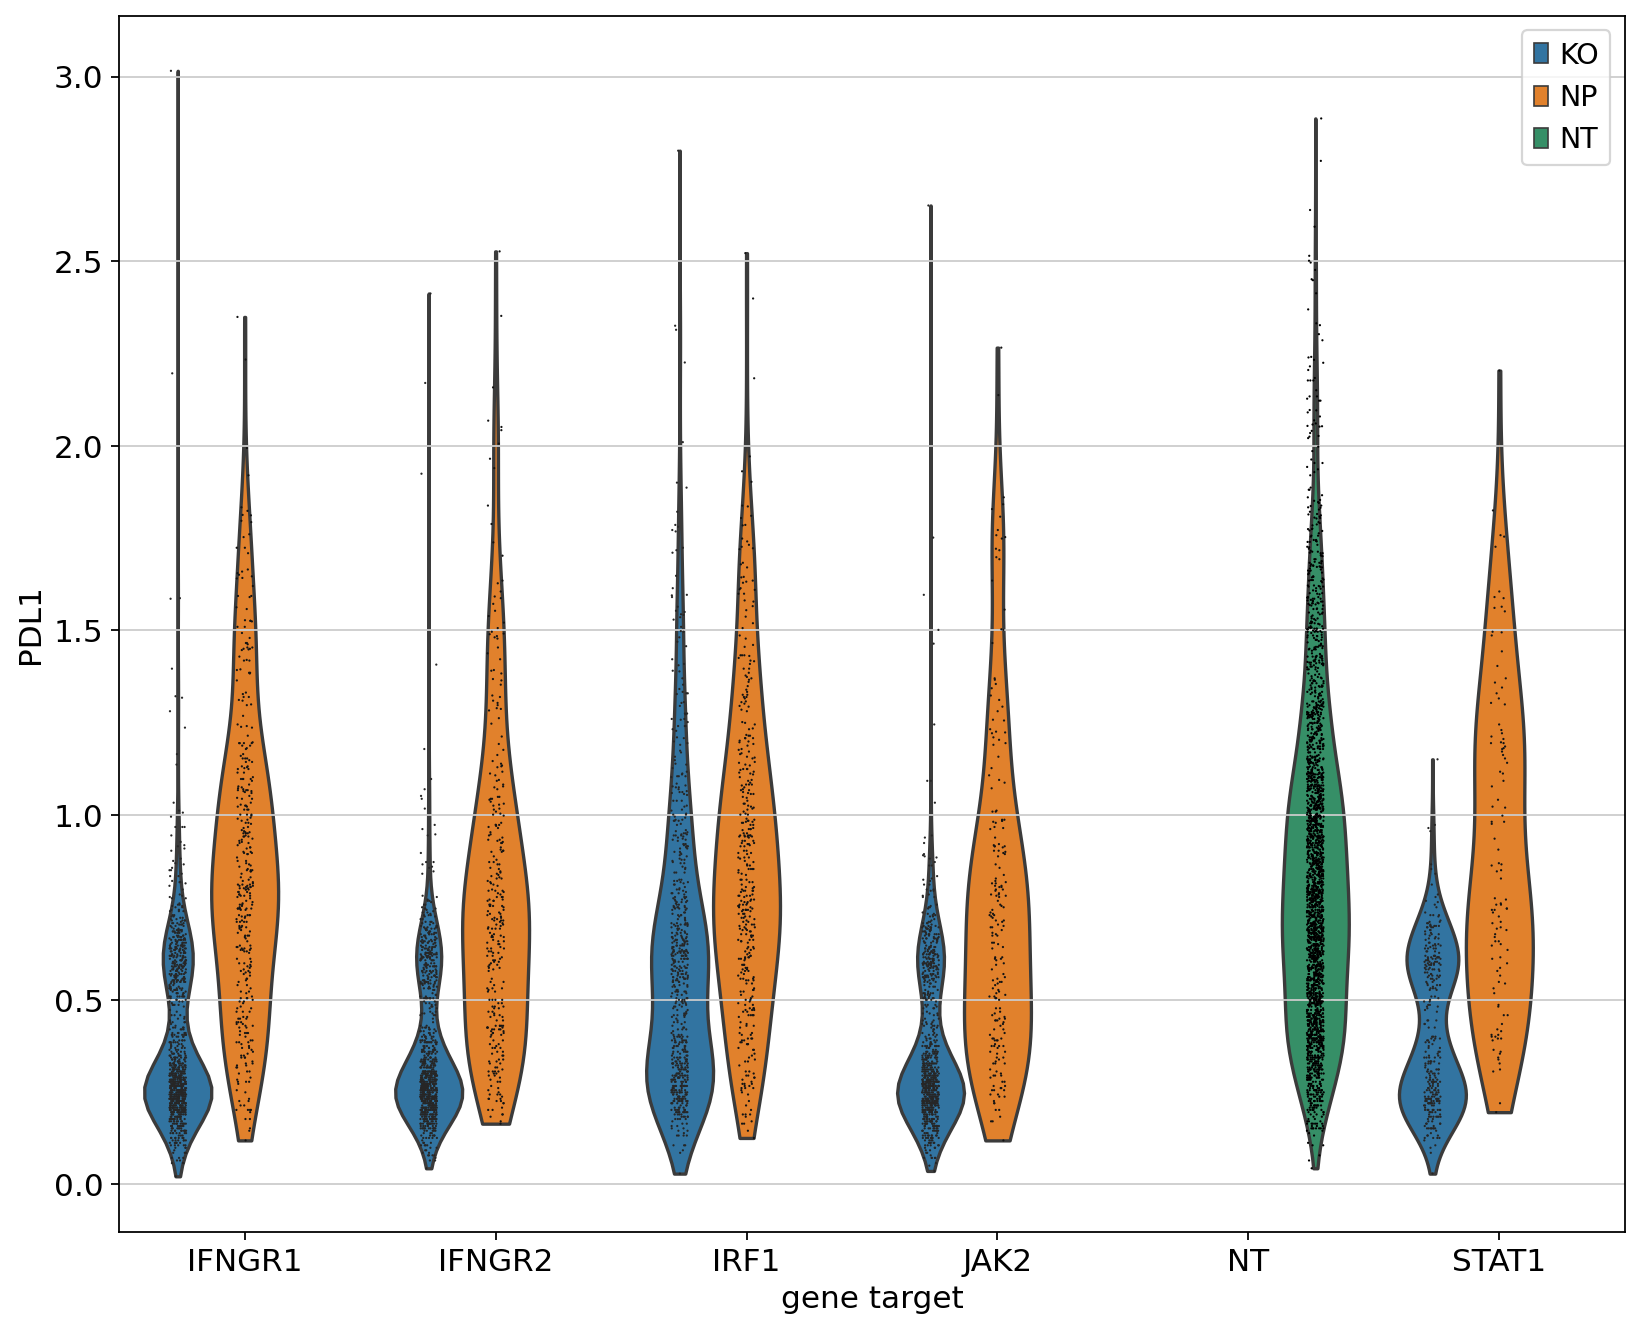

In [28]:
mdata["adt"].obs["mixscape_class_global"] = mdata["rna"].obs["mixscape_class_global"]
pt.pl.ms.violin(
    adata=mdata["adt"],
    target_gene_idents=["NT", "JAK2", "STAT1", "IFNGR1", "IFNGR2", "IRF1"],
    keys="PDL1",
    groupby="gene_target",
    hue="mixscape_class_global",
)

### Visualizing perturbation responses with Linear Discriminant Analysis

The final step in the Mixscape pipeline is to calculate and visualize perturbation-specific clusters. This is done by applying linear discriminant analysis (LDA) and recalculating the UMAP using the determined results. LDA attempts to maximize the separability of known labels, which are the mixscape classes in our case, using both gene expression and the labels.

In [29]:
ms.lda(adata=mdata["rna"], labels="gene_target", layer="X_pert")

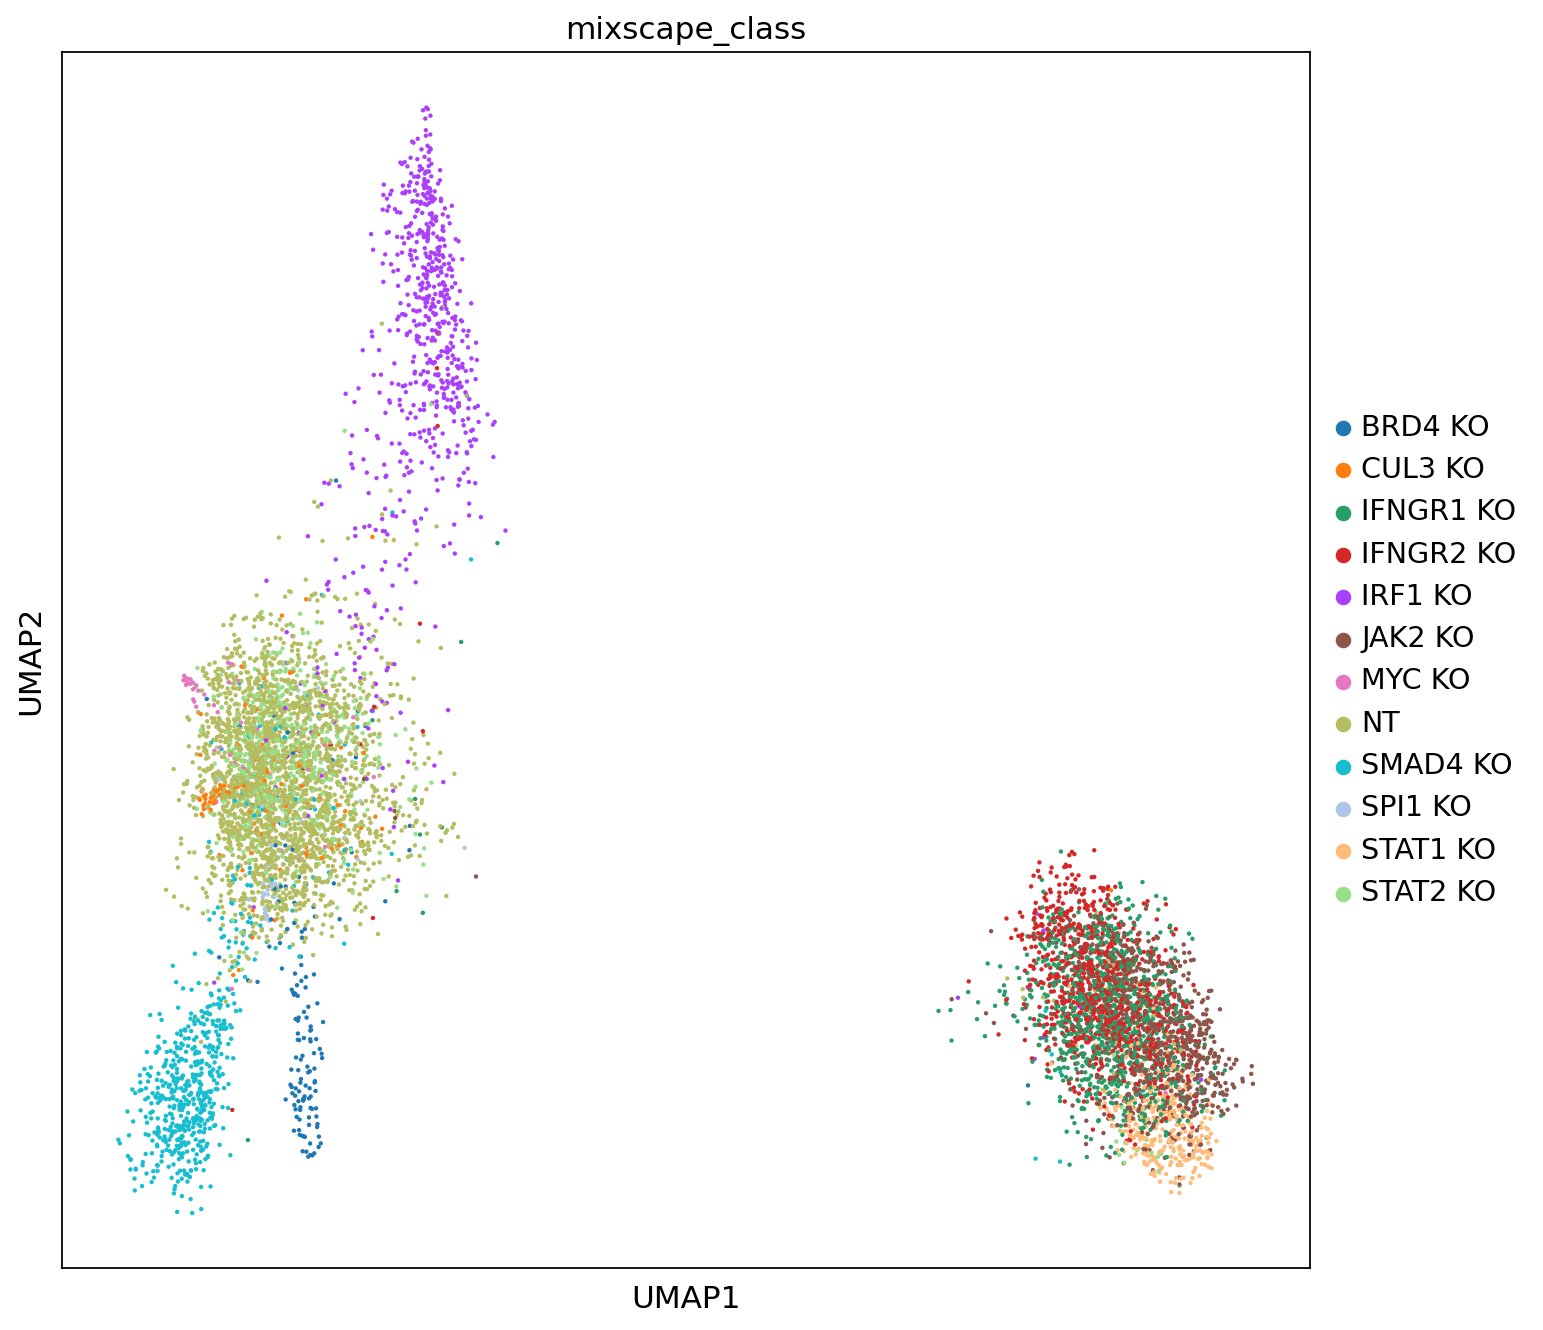

In [30]:
pt.pl.ms.lda(adata=mdata["rna"])

The LDA highlights at least two major types of perturbations as evident by the two islands. However, we want to emphasize that only more stringent analysis such as pathway analysis followed by biological validation, could determine that several knockouts have similar effects.

## Key Takeaways

1. When applying Augur ensure that the cell types can be confidently labeled. Use differential abundance tests to find confounding effects and differential gene expression to find gene-level sources of perturbation effects.
2. Predicting perturbation responses with tools such as scGen works well for highly expressed genes, but is challenging for lowly expressed genes.
3. The linear discriminant analysis step of the Mixscape pipeline primarily aids with visualization. Distances in UMAPs should be interpreted with caution and therefore similarities and differences between knockouts cannot always be inferred at a glance.

## Quiz

1. Why is it required to have confident cell type labels when applying Augur?
2. Why should scGen primarily only be applied to highly expressed genes?
3. The mixscape pipeline results in clusters of genetic perturbations. Why must the distances in the UMAPs be interpreted with caution? What does it mean when some genetic perturbations are close or distant in the UMAP embedding?

## References

```{bibliography}
:filter: docname in docnames
```